# Surplux Solar Energy

## Import Package

In [8]:
import os
import math
import random
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [9]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Helper Functions
Before we write the code for adjusting the models, lets define a few helper functions.

In [10]:
# Get the station ID of the recent station measurement
def get_recent_station(lon, lat, stations):
    distances = list(stations.apply(lambda station: get_geodistance(lon, lat, station['Lon'], station['Lat']), axis=1))
    return distances.index(min(distances))
# Calculate distance based on latitude and longitude
def get_geodistance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2-lon1
    dlat = lat2-lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * \
        math.cos(lat2) * math.sin(dlon/2)**2
    distance = 2*math.asin(math.sqrt(a))*6371*1000
    return distance

In [11]:
# group by location
def group_by_location(df):
    return df.groupby(['Lat', 'Lon']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
# group by module & capacity & location
def group_by_module_capacity_location(df):
    return df.groupby(['Module', 'Lat', 'Lon', 'Capacity']) \
        .mean() \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
# filter by module & capacity & location
def filter_by_module_capacity_location(df, module, capacity, lat, lon):
    return df[df['Lat'].eq(lat) & df['Lon'].eq(lon) & df['Module'].eq(module) & df['Capacity'].eq(capacity)]


In [12]:
# Day of Year & Day of Year (Transformed)
def data_preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    # data['DayOfYear'] = data['Date'].dt.dayofyear/366
    # data['DayOfYearTransformed'] = data['Date'].dt.dayofyear.apply(transform_day_of_year)
    # 1 kwh = 3.6 MJ
    # 1 MJ to kwh = 0.27778 kwh
    data['Irradiance'] = data['Irradiance'] / 3.6
    # data['Irradiance_m'] = data['Irradiance_m'] / 1000
    # Capacity Factor compare the power generation efficiency between plants of different scale.  
    # data['CapacityFactor'] = data['Generation']/data['Capacity']
    # Array Ratio compares the energy collected through the system to the total system load by dividing energy in by energy-out. 
    # data['ArrayRatio'] = data['CapacityFactor']/data['Irradiance']
    # data['ArrayRatio_m'] = data['CapacityFactor']/data['Irradiance_m']
    data = data.rename(columns={'Generation': 'Generation(kWd)', 'Irradiance': 'Irradiance(kWd/m2)'})
    return data

In [13]:
from pvlib.location import Location
def get_clear_sky_irradiance(lon, lat, start, end):
    # Clearsky must be get in the same timezone as the location, because the clearsky model is timezone-dependent.
    location = Location(lat, lon, 'Asia/Taipei')
    # Clearsky must be get in a date range.
    times = pd.date_range(start=start, end=end + datetime.timedelta(days=1), freq='1h', tz=location.tz)
    data = location.get_clearsky(times).reset_index()
    data['Datetime'] = pd.to_datetime(data['index']).dt.tz_localize(None)
    # 1 kW = 1000 W 
    data['ClearSkyIrradiance(kWh/m2)'] = data['ghi']/1000
    return data[['Datetime', 'ClearSkyIrradiance(kWh/m2)']]

In [14]:
def get_cwb_observation(stationID):
    def remove_str(x):
        try: return float(x)
        except: return np.nan
    # Read observation data from local file, you need to grab those files from the website first.
    data = pd.read_csv(os.path.join(path, f'data/observation(cwb)/{stationID}.csv'))
    # Remove the special word of each attribute, such as 'T', 'x', 'V', '/', ...
    for column in data.columns[5:]:
        data[column] = data[column].apply(lambda x: remove_str(x))
    # 1 kwh = 3.6 mj
    # 1 MJ to kwh = 0.27778 kwh
    data['GloblRad'] = data['GloblRad'].astype(float) / 3.6
    # Time format conversion: ObStime is 1 ~ 24, and should be adjusted to 0 ~ 23
    data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + (data['ObsTime']-1).astype(str) + ':00:00')
    data = data.rename(columns={"GloblRad": "Irradiance(kWh/m2)"})
    return data[['Datetime', 'Irradiance(kWh/m2)']]

In [15]:
def transform_day_of_year(day_of_year):
    """transform day_of_year through winter solstice and summer solstice.

    summer solstice = 173, winter solstice = 356.

    Args:
        day_of_year(int): day of year. (1 to 366)

    Returns:
        int: day of year been transformed. (0.0 to 1.0)
    """

    if(day_of_year > 356):
        return (day_of_year-356)/((173+366)-356)
    elif(day_of_year < 173):
        return (day_of_year+366-356)/((173+366)-356)
    else:
        return 1-((day_of_year-173)/(356-173))

In [16]:
# linear interpolation
from scipy.interpolate import interp1d
def interpolate(x, kind='linear'):
    not_nan = np.logical_not(np.isnan(x))
    indices = np.arange(len(x))
    interp = interp1d(indices[not_nan], x[not_nan], kind=kind)
    # interp = interp1d(indices[not_nan], x[not_nan], kind=kind, fill_value="extrapolate")
    # interp = interp1d(indices[not_nan], x[not_nan], kind=kind, bounds_error=False, fill_value=np.nan)
    return interp(indices)

In [17]:
# evaluate
def RMSE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) ** 2).mean())

## Const & Inputs
Here are all of the parameters to change for the run.

In [18]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

## Data Preprocessing: Load Data

In [20]:
train = pd.read_csv(os.path.join(path, 'data/train.csv'))
train = data_preprocessing(train)
train = train.drop(['Irradiance_m', 'Temp_m', 'Temp'], axis=1)
train = train.dropna(axis=0)
train.insert(0, 'Set', 'train')
train.describe()

,ID,Generation(kWd),Irradiance(kWd/m2),Capacity,Lat,Lon,Angle
count,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000
mean,1800.654494,1341.022191,4.796601,350.021034,24.480935,120.757309,-20.473837
std,1033.142458,797.035683,1.894333,144.511213,0.482053,0.347354,52.814505
min,1.000000,17.000000,0.036111,99.200000,24.040000,120.440000,-160.000000
25%,914.750000,575.000000,3.658333,246.400000,24.080000,120.470000,-31.000000
50%,1804.500000,1269.000000,5.213889,352.000000,24.107000,120.520000,1.760000
75%,2694.250000,1959.000000,6.247917,498.560000,25.030000,121.080000,4.630000
max,3584.000000,6752.000000,8.005556,499.800000,25.110000,121.260000,22.000000


In [21]:
test = pd.read_csv(os.path.join(path, 'data/test.csv'))
test = data_preprocessing(test)
test = test.drop(['Irradiance_m', 'Temp_m', 'Temp'], axis=1)
test.insert(0, 'Set', 'test')
test.describe()

,ID,Generation(kWd),Irradiance(kWd/m2),Capacity,Lat,Lon,Angle
count,1539.000000,0.0,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000
mean,770.000000,NaN,3.378431,335.654321,24.358381,120.680032,-17.387479
std,444.415346,NaN,1.399051,132.486180,0.444123,0.309303,47.846896
min,1.000000,NaN,0.261111,99.200000,24.040000,120.440000,-160.000000
25%,385.500000,NaN,2.277778,267.520000,24.070000,120.470000,-2.620000
50%,770.000000,NaN,3.866667,314.880000,24.080000,120.520000,0.000000
75%,1154.500000,NaN,4.525000,492.800000,24.980000,121.030000,4.630000
max,1539.000000,NaN,5.611111,499.800000,25.110000,121.260000,22.000000


In [22]:
stations = pd.read_csv(os.path.join(path, 'data/cwb_meta.csv'))
stations = stations[stations['StationID'].str.contains("^46")].reset_index(drop=True)
stations = stations[pd.to_datetime(stations['StartDate']) <= pd.to_datetime(train['Date'].min())].reset_index(drop=True)
stations.head(3)

,StationID,StationName,Altitude,City,Lon,Lat,Address,StartDate
0,466850,五分山雷達站,756.0,新北市,121.781205,25.071182,瑞芳區靜安路四段1巷1號,1988-07-01
1,466880,板橋,9.7,新北市,121.442017,24.997647,板橋區大觀路二段265巷62號,2002-01-01
2,466900,淡水,19.0,新北市,121.448906,25.164889,淡水區中正東路42巷6號,1942-10-01


In [23]:
train_group = group_by_module_capacity_location(train)
train_group['StationID'] = train_group.apply(lambda row: stations['StationID'][get_recent_station(row['Lon'], row['Lat'], stations)], axis=1)
train_group['StationID'].unique()

array(['466900', '467050', '467770', '467490', '467270'], dtype=object)

## Data Preprocessing: Day to Hour

Check the start date and end date of both train and test data.

In [24]:
date_range = pd.DataFrame(columns=['Filter', 'TrainStartDate', 'TrainEndDate', 'TestStartDate', 'TestEndDate'])
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    test_idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    date_range.loc[i] = [f"{row['Module']}({row['Capacity']})", train_idf['Date'].min(), train_idf['Date'].max(), test_idf['Date'].min(), test_idf['Date'].max()]
date_range

,Filter,TrainStartDate,TrainEndDate,TestStartDate,TestEndDate
0,MM60-6RT-300(438.3),2020-12-14,2021-10-28,2021-10-29,2022-02-17
1,MM60-6RT-300(499.8),2020-06-09,2021-10-28,2021-10-29,2022-02-17
2,MM60-6RT-300(498.6),2020-12-17,2021-10-28,2021-10-29,2022-02-17
3,SEC-6M-60A-295(283.2),2020-12-17,2021-10-28,2021-10-29,2022-02-17
4,AUO PM060MW3 320W(246.4),2020-09-24,2021-10-28,2021-10-29,2022-02-16
5,AUO PM060MW3 320W(492.8),2020-09-23,2021-10-28,2021-10-29,2022-02-16
6,AUO PM060MW3 320W(278.4),2021-05-21,2021-10-28,2021-10-29,2022-02-16
7,AUO PM060MW3 320W(267.52),2021-05-21,2021-10-28,2021-10-29,2022-02-16
8,AUO PM060MW3 325W(343.2),2021-10-09,2021-10-28,2021-10-29,2022-02-16
9,AUO PM060MW3 320W(99.2),2020-09-27,2021-10-28,2021-10-29,2022-02-16


Because train and test data have time coherent, we can merge them first when we make preprocessing.

In [25]:
full = pd.concat([train, test], axis=0)
full = full.sort_values(by=['Date', 'ID'], ignore_index=True)
full.tail(5)

,Set,ID,Date,Generation(kWd),Irradiance(kWd/m2),Capacity,Lat,Lon,Angle,Module
5094,test,1535,2022-02-16,NaN,5.600000,343.2,24.08,120.52,-2.62,AUO PM060MW3 325W
5095,test,1536,2022-02-17,NaN,1.797222,499.8,25.11,121.26,22.00,MM60-6RT-300
5096,test,1537,2022-02-17,NaN,1.797222,438.3,25.11,121.26,-160.00,MM60-6RT-300
5097,test,1538,2022-02-17,NaN,1.938889,283.2,24.98,121.03,-31.00,SEC-6M-60A-295
5098,test,1539,2022-02-17,NaN,1.938889,498.6,25.03,121.08,-95.00,MM60-6RT-300


Merge hourly data by each group of module & capacity & location

In [26]:
full_by_hours = pd.DataFrame()
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    idf = filter_by_module_capacity_location(full, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    
    # Repeat the daily data by 24 times to hourly data
    idf = pd.concat([idf]*24, ignore_index=True).sort_values(by=['Date'], ignore_index=True)
    idf['Datetime'] = pd.to_datetime(idf['Date'].astype(str) + ' ' + (np.array(idf.index)%24).astype(str) + ':00:00')
    
    # Handle csr & Merge based on the competition data
    csr = get_clear_sky_irradiance(row['Lon'], row['Lat'], idf['Date'].min() - datetime.timedelta(days=7+1), idf['Date'].max())
    idf = pd.merge(idf, csr, on=['Datetime'], how='outer')
    
    # Handle cwb observation & Merge based on the competition data
    cwb = get_cwb_observation(row['StationID'])
    # Filer the cwb observation data by the date range of the data
    cwb = cwb[(cwb['Datetime'] >= idf['Datetime'].min() - datetime.timedelta(days=7+1)) & (cwb['Datetime'] <= idf['Datetime'].max())]
    idf = pd.merge(idf, cwb, on=['Datetime'], how='outer')
    
    # Set Module, Capacity, Lat, Lon for the outer data
    idf['Module'] = row['Module']
    idf['Capacity'] = row['Capacity']
    idf['Lat'] = row['Lat']
    idf['Lon'] = row['Lon']
    idf['Angle'] = row['Angle']
    idf['Date'] = idf['Datetime'].dt.date
    idf['DayOfYear'] = idf['Datetime'].dt.dayofyear/366
    idf['DayOfYearTransformed'] = idf['Datetime'].dt.dayofyear.apply(transform_day_of_year)
    
    # Reconcatenate the data as a single dataframe
    full_by_hours = pd.concat([full_by_hours, idf], ignore_index=True)
full_by_hours.describe()

,ID,Generation(kWd),Irradiance(kWd/m2),Capacity,Lat,Lon,Angle,ClearSkyIrradiance(kWh/m2),Irradiance(kWh/m2),DayOfYear,DayOfYearTransformed
count,122376.000000,85440.000000,122376.000000,129374.000000,129374.000000,129374.000000,129374.000000,126878.000000,129374.000000,129374.000000,129374.000000
mean,1489.578349,1341.022191,4.368564,345.542571,24.439243,120.730763,-19.524827,0.250299,0.167494,0.537860,0.447906
std,1014.118964,796.928396,1.875882,140.771424,0.472929,0.337015,51.299200,0.328156,0.256362,0.309391,0.301598
min,1.000000,17.000000,0.036111,99.200000,24.040000,120.440000,-160.000000,0.000000,0.000000,0.002732,0.000000
25%,644.000000,575.000000,2.991667,267.520000,24.080000,120.470000,-2.620000,0.000000,0.000000,0.267760,0.180328
50%,1287.000000,1269.000000,4.583333,343.200000,24.107000,120.520000,1.760000,0.000000,0.000000,0.579235,0.398907
75%,2310.000000,1959.000000,5.786111,498.560000,25.030000,121.080000,4.630000,0.548661,0.275000,0.808743,0.721311
max,3584.000000,6752.000000,8.005556,499.800000,25.110000,121.260000,22.000000,0.976842,1.180556,1.000000,1.000000


In [27]:
# full_group_from_hours = full_by_hours.groupby(['Module', 'Capacity', 'Lat', 'Lon', 'Date']) \
#     .agg({'Generation(kWd)': 'mean', 'Irradiance(kWd/m2)': 'mean', 'ClearSkyIrradiance(kWh/m2)': 'sum', 'Irradiance(kWh/m2)': 'sum'}) \
#     .reset_index() \
#     .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
# full_group_from_hours.describe()
# # Calculate the number relationship
# full_group_from_hours.corr()

## Modelling + Training

In [37]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from sklearn_rvm import EMRVR
from sklearn.model_selection import train_test_split

In [140]:
outliers = [
    {
        'irradiance': [],
        'generation': ['2021-09-10', '2021-09-14', '2021-09-21', '2021-09-23', '2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07']
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-01-28', '2021-05-14']
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-05-14']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-03-07']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2021-08-04'],
        'generation': ['2021-07-19']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
]

In [136]:
def get_inputs(target_data, history_data):
    daily_attribute = target_data[['DayOfYearTransformed']].values.mean(axis=0)
    hourly_attribute = np.concatenate((
        history_data['ClearSkyIrradiance(kWh/m2)'].values,
        history_data['Irradiance(kWh/m2)'].values
    ))
    inputs = np.concatenate((daily_attribute, hourly_attribute))
    return inputs

def get_outputs(target_data):
    outputs = target_data[['Generation(kWd)']].values.mean(axis=0)
    return outputs

def get_batch_by_date(target_day, data, days=0):    
    history_days = pd.date_range(target_day - datetime.timedelta(days=days), target_day)
    target_data = data[data['Date'].eq(target_day)].reset_index(drop=True)
    history_data = data[data['Date'].isin(history_days.date)].reset_index(drop=True)
    x = get_inputs(target_data, history_data)
    y = get_outputs(target_data)
    return np.array(x), np.array(y)

def get_dataset_by_date_list(date_list, data, days=0):
    x_list, y_list = [], []
    for date in date_list:
        x, y = get_batch_by_date(date, data, days)
        x_list.append(x)
        y_list.append(y)
    return np.array(x_list), np.array(y_list)

In [142]:
train_idf.index.isin(outliers2)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

(242, 49) (242, 1) (112, 49) (112, 1)


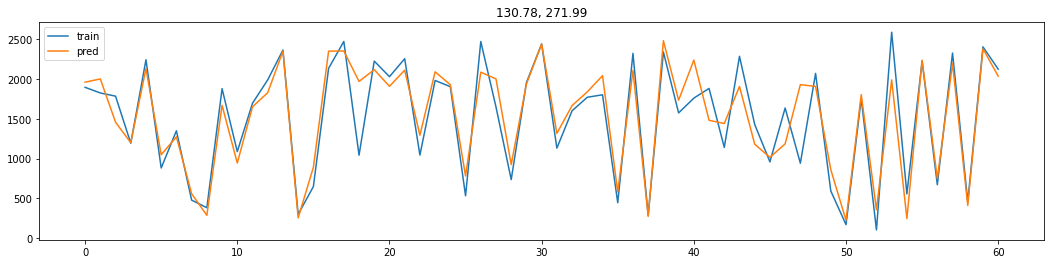

(396, 49) (396, 1) (112, 49) (112, 1)


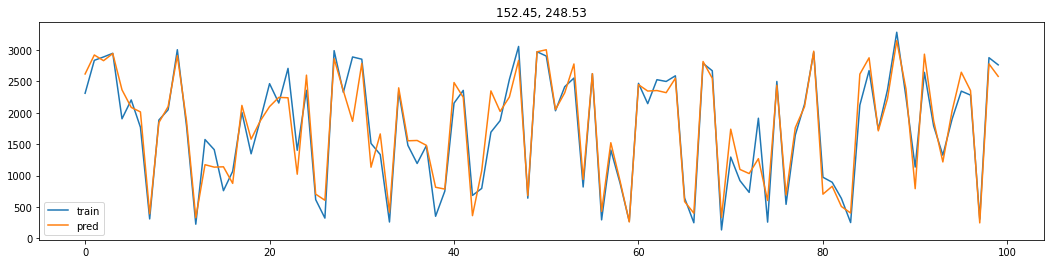

(252, 49) (252, 1) (104, 49) (104, 1)


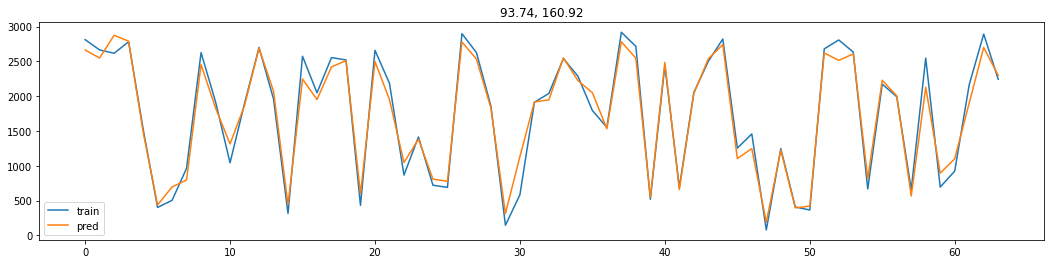

(252, 49) (252, 1) (112, 49) (112, 1)


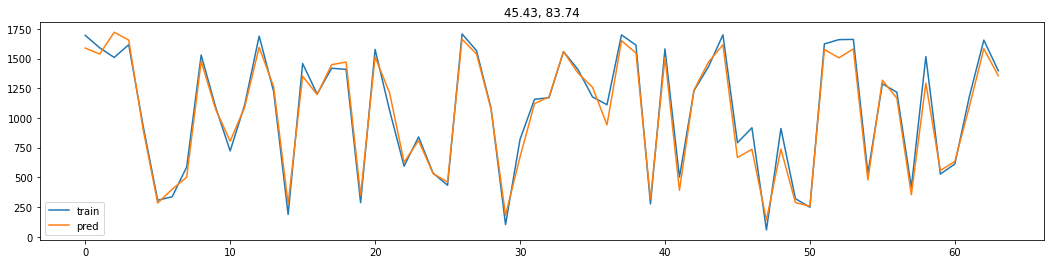

(312, 49) (312, 1) (107, 49) (107, 1)


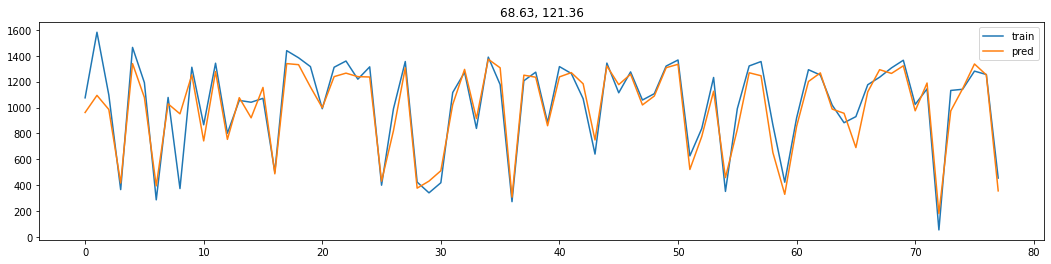

(311, 49) (311, 1) (107, 49) (107, 1)


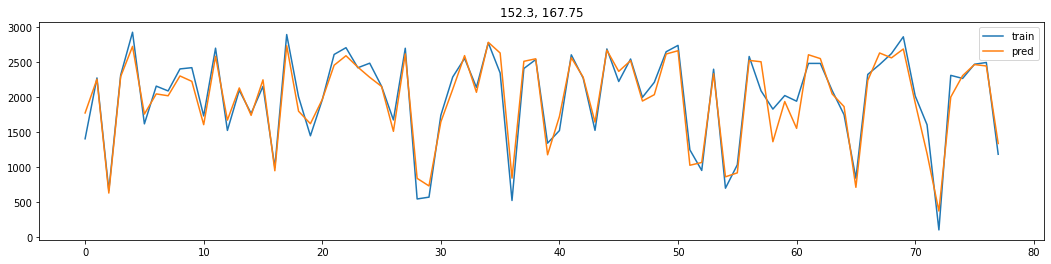

(126, 49) (126, 1) (111, 49) (111, 1)


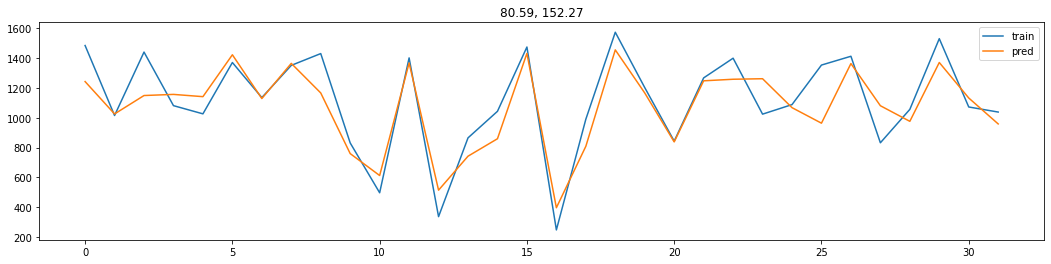

(128, 49) (128, 1) (111, 49) (111, 1)


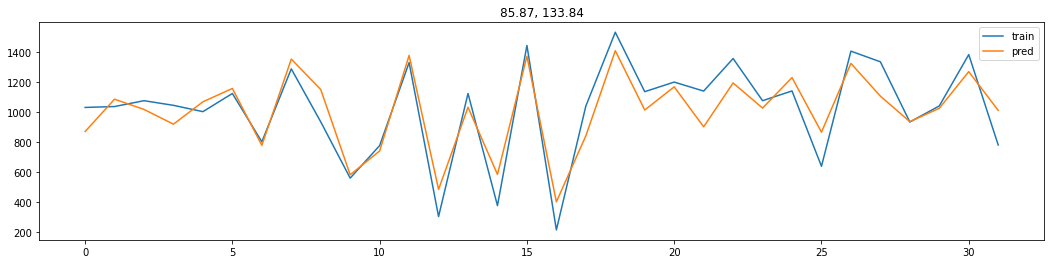

(16, 49) (16, 1) (111, 49) (111, 1)


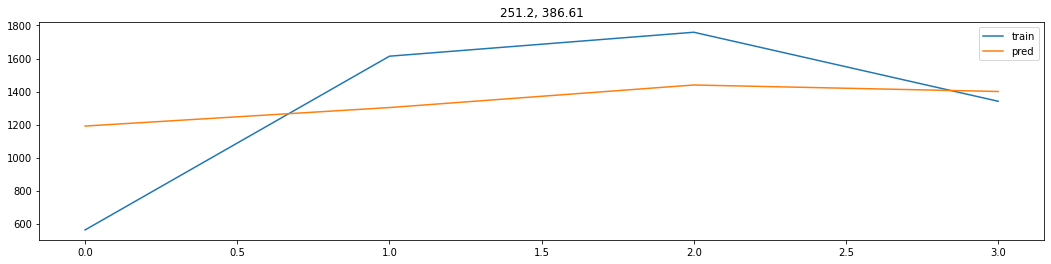

(310, 49) (310, 1) (111, 49) (111, 1)


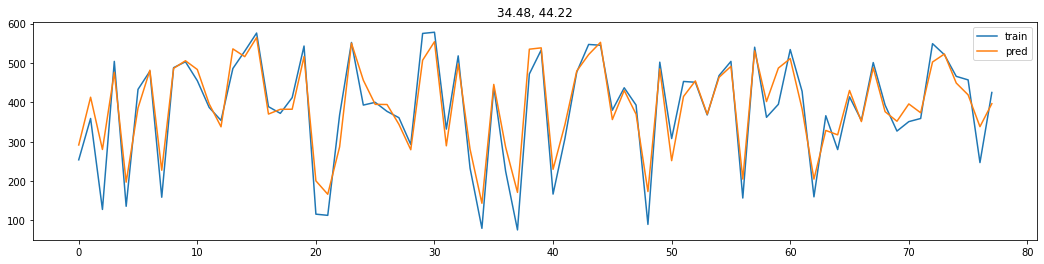

(128, 49) (128, 1) (111, 49) (111, 1)


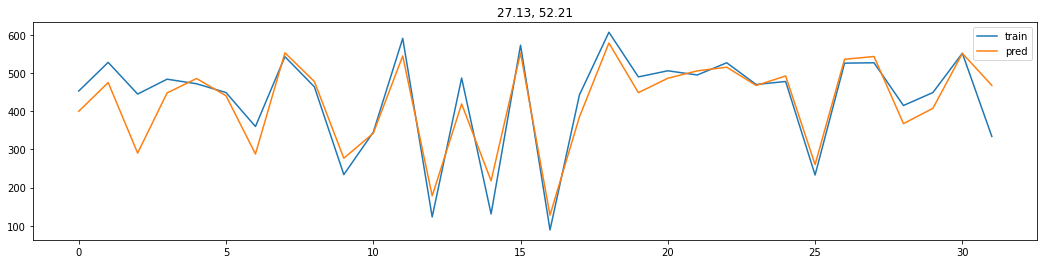

(123, 49) (123, 1) (111, 49) (111, 1)


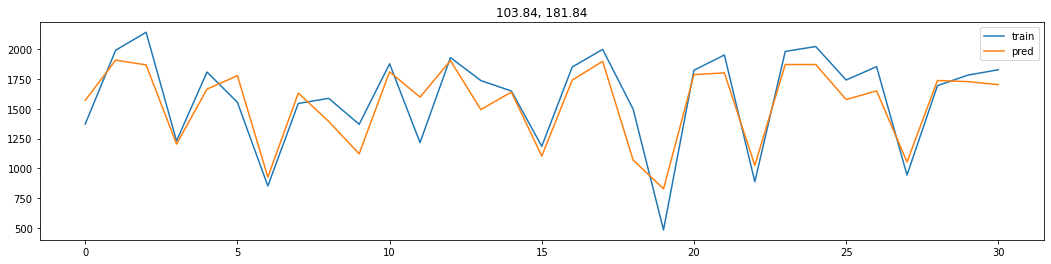

(104, 49) (104, 1) (110, 49) (110, 1)


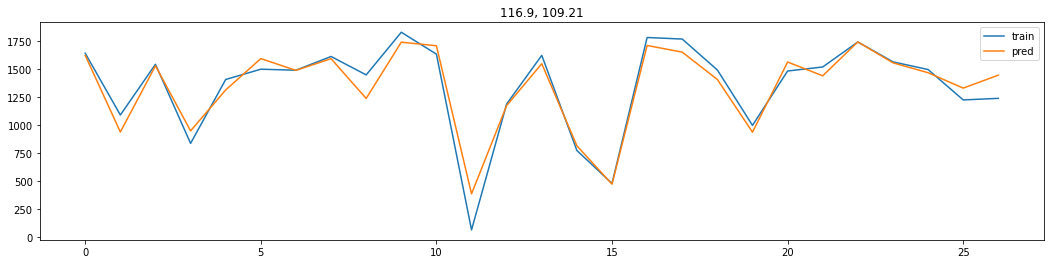

(129, 49) (129, 1) (109, 49) (109, 1)


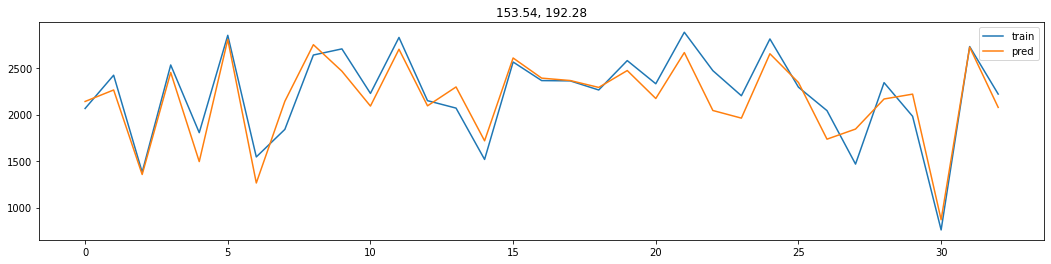

In [176]:
for i, row in train_group.iterrows():
    # Filter the data by module & capacity & location
    train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    test_idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    full_by_hours_idf = filter_by_module_capacity_location(full_by_hours, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    
    outliers2 = train_idf[train_idf['Date'].isin(pd.to_datetime(outliers[i]['generation']).date)].index.tolist()
    train_idf = train_idf[~(train_idf.index.isin(outliers2))]
    
    # build x, y for train and test data
    train_x, train_y = get_dataset_by_date_list(train_idf['Date'].unique(), full_by_hours_idf, 0)
    test_x, test_y = get_dataset_by_date_list(test_idf['Date'].unique(), full_by_hours_idf, 0)
    
    # Split vaild from train data
    train_x, vaild_x, train_y, vaild_y = train_test_split(train_x, train_y, test_size = 0.2, random_state=SEED)

    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    
    # Modelling
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.01,
        colsample_bytree=0.1,
        seed=SEED,
        subsample=0.1,
        min_child_weight=1,
        n_estimators=1000
    ).fit(train_x, train_y.reshape(-1))
    
    # Pred
    pred_train_y = model.predict(train_x).reshape(-1, 1)
    pred_vaild_y = model.predict(vaild_x).reshape(-1, 1)
    pred_test_y = model.predict(test_x).reshape(-1, 1)
    
    train_error = round(RMSE(train_y, pred_train_y),2)
    vaild_error = round(RMSE(vaild_y, pred_vaild_y),2)
    
    plt.figure(figsize=(18, 4))
    plt.title(f'{train_error}, {vaild_error}')
    plt.plot(vaild_y, label='true')
    plt.plot(pred_vaild_y, label='pred')
    plt.legend()
    plt.show()
    
    # print(, round(RMSE(vaild_y, pred_vaild_y),2))
    
    # Set Generation of test data from the pred value
    test.loc[test_idf.index, 'Generation(kWd)'] = pred_test_y
    

In [163]:
row = train_group.iloc[0]
# Filter the data by module & capacity & location
train_idf = filter_by_module_capacity_location(train, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
test_idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
full_by_hours_idf = filter_by_module_capacity_location(full_by_hours, row['Module'], row['Capacity'], row['Lat'], row['Lon'])

outliers2 = train_idf[train_idf['Date'].isin(pd.to_datetime(outliers[0]['generation']).date)].index.tolist()
train_idf = train_idf[~(train_idf.index.isin(outliers2))]
    
# build x, y for train and test data
train_x, train_y = get_dataset_by_date_list(train_idf['Date'].unique(), full_by_hours_idf)
test_x, test_y = get_dataset_by_date_list(test_idf['Date'].unique(), full_by_hours_idf)

# Split vaild from train data
train_x, vaild_x, train_y, vaild_y = train_test_split(train_x, train_y, test_size = 0.2, random_state=SEED)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

9
(242, 49) (242, 1) (112, 49) (112, 1)


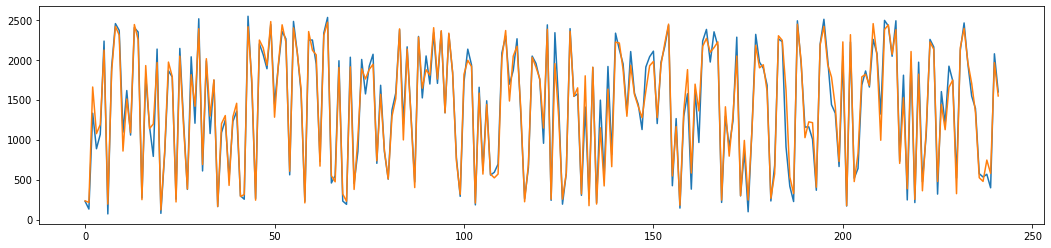

In [174]:
plt.figure(figsize=(18, 4))
plt.plot(train_y, label='train')
plt.plot(pred_train_y, label='pred')
plt.show()

In [139]:
model = SVR(kernel='rbf').fit(train_x, train_y.reshape(-1))
pred_train_y = model.predict(train_x).reshape(-1, 1)
pred_vaild_y = model.predict(vaild_x).reshape(-1, 1)
print(round(RMSE(train_y, pred_train_y),2), round(RMSE(vaild_y, pred_vaild_y),2))

725.49 806.25


In [53]:
model = lgb.LGBMRegressor().fit(train_x, train_y.reshape(-1))
# 1+7D
# 58.66165654445877
# 317.54787419496836
# 1+3D
# 67.4845331227586
# 283.9947750434095
# 1+0D
# 112.61875800940963
# 245.76228583154122


In [165]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    colsample_bytree=0.1,
    seed=SEED,
    subsample=0.1,
    min_child_weight=1,
    n_estimators=1000
).fit(train_x, train_y.reshape(-1))
pred_train_y = model.predict(train_x).reshape(-1, 1)
pred_vaild_y = model.predict(vaild_x).reshape(-1, 1)
print(round(RMSE(train_y, pred_train_y),2), round(RMSE(vaild_y, pred_vaild_y),2))
# 7D
# 0.013448159399461668
# 362.13862265910984
# 3D
# 0.005796302722998175
# 274.6546351342357
# 1+0D
# 0.10929316877660708
# 231.15511157188337
# 1D, IDSL
# 216.14418713233272
# 222.27645344257954
# 1D, IDSL(drop outlier)
# 130.78 
# 271.99


130.78 271.99


In [204]:
fix = pd.read_csv('./submission/test_generation(location).csv')
test['Fix'] = fix['Generation']

In [162]:
submission = test[['ID', 'Generation(kWd)']].copy()
submission = submission.rename(columns={'Generation(kWd)': 'Generation'})
submission.to_csv(os.path.join(path, f'submission/xgb-1d-drop-outlier.csv'), index=False)

In [200]:
need_fix = test[test['Module'].eq('AUO PM060MW3 325W')].index
test.loc[need_fix, 'Generation(kWd)'] = fix.loc[need_fix, 'Generation']

In [201]:
submission = test[['ID', 'Generation(kWd)']].copy()
submission = submission.rename(columns={'Generation(kWd)': 'Generation'})
submission.to_csv(os.path.join(path, f'submission/(fix)xgb-1d-drop-outlier.csv'), index=False)

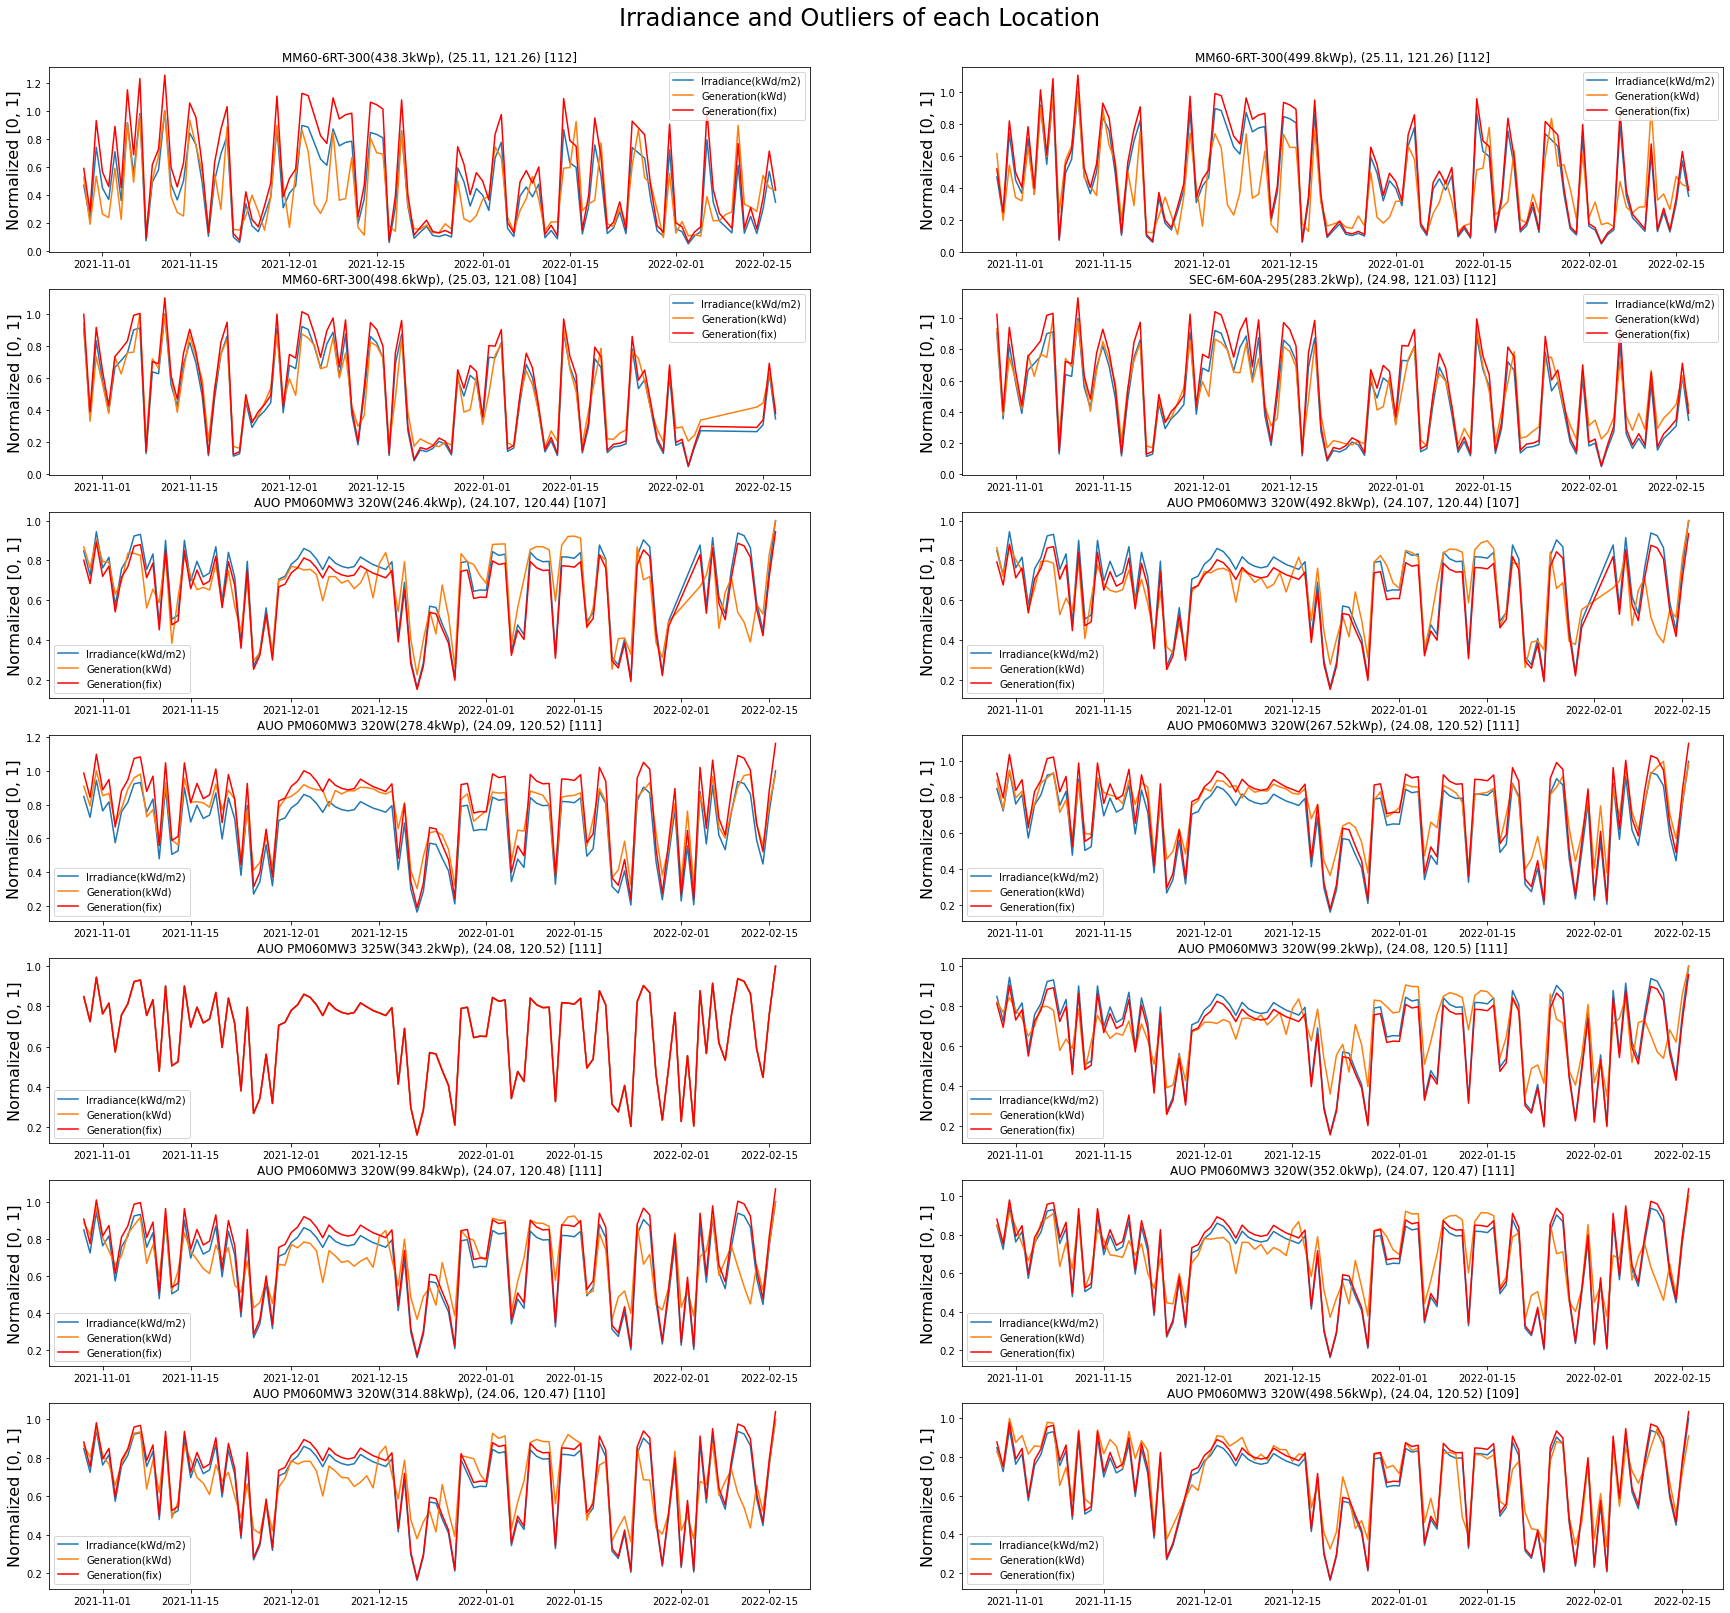

In [211]:
plt.figure(figsize=(30, 28))
plt.suptitle('Irradiance and Outliers of each Location', fontsize=24, y=0.91)
for i, row in train_group.iterrows():
    idf = filter_by_module_capacity_location(test, row['Module'], row['Capacity'], row['Lat'], row['Lon'])
    plt.subplot(math.ceil(len(train_group)/2), 2, i+1)
    plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]")
    plt.plot(idf['Date'], idf['Irradiance(kWd/m2)']/idf['Irradiance(kWd/m2)'].max(), label='Irradiance(kWd/m2)')
    plt.plot(idf['Date'], idf['Generation(kWd)']/idf['Generation(kWd)'].max(), label='Generation(kWd)')
    plt.plot(idf['Date'], idf['Fix']/idf['Generation(kWd)'].max(), label='Generation(fix)', color='red')
    # plt.ylabel('kWh/m²', fontsize=16)
    plt.ylabel('Normalized [0, 1]', fontsize=16)
    plt.legend() 